In [1]:
import numpy as np
import matplotlib.pyplot as plt

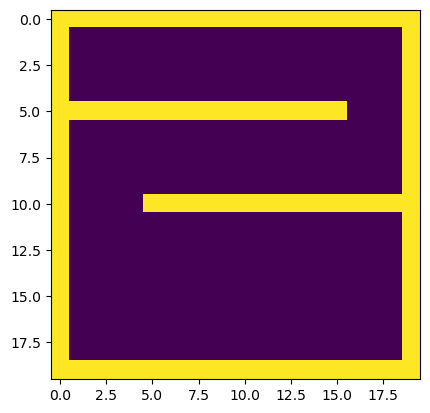

In [2]:
reality = -(np.pad(np.ones((18,18)),1)  - 1)
for ((wx1,wy1),(wx2,wy2)) in [((5,0),(5,15)),((10,5),(10,20))]:
    reality[wx1:wx2+1,wy1:wy2+1] = 1
    
plt.imshow(reality)
plt.show()

In [3]:
robot_real = {
    "position": (2,3),
    "rotation": 0, #degrees
    "sonar_p": (.97, .1),
    "pos_p": (.99, .2),
    "rot_p": (1.04, .2)
}

robot_belief = {
    "position": (2,3),
    "rotation": 0, #degrees
    "sonar_p": (.99, .09),
    "pos_p": (1.02, .22),
    "rot_p": (1.0, .21)
}

In [4]:
import math

def sonar(real, step=.3):
    position = real["position"]
    r = real["rotation"]
    orientation = np.array([math.cos(r), math.sin(r)])

    dist = 0
    while(reality[int(position[0]),int(position[1])] != 1):
        dist += step
        position += orientation * step     
    
    return int(np.random.normal(*real["sonar_p"]) * dist)

sonar(robot_real)

3

<function matplotlib.pyplot.show(close=None, block=None)>

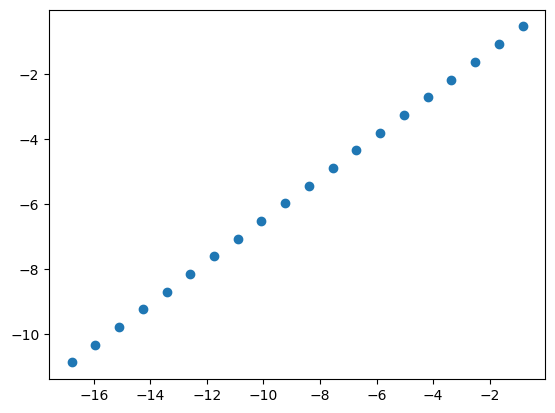

In [5]:
# IDEA
# draw curve
#

import math

robot = {
    "speed": 0,
    "position": np.array([0,0]),
    "angle": 10
}

def angle_to_vector(a):
    return np.array([math.cos(a),math.sin(a)])

def move(robot):
    return {
        "speed": robot["speed"],
        "position": robot["position"] + angle_to_vector(robot["angle"]),
        "angle": robot["angle"]
    }

def curve(robot, bezier, step=0):
    # the bezier curve is 2 x (+x,+y)
    start = np.array([0,0])

res = []
for i in range(20):
    robot = move(robot)
    res.append(robot["position"])

plt.scatter(*np.array(res).T)
plt.show

In [77]:
import sched, time

class FakeRobot():
    def __init__(self, sched=True):
        self.speed = np.array([0.,0.])
        self.pos   = np.array([0.,0.])
        self.width = 0.5 # meters
        self.rotation = 0 # rads

        self.pos_history   = [np.array([0.,0.])]
        self.speed_history = [np.array([0.,0.])]

        if sched:
            scheduler = sched.scheduler()
            scheduler.enter(.1, 1, self._step, (scheduler,))
            scheduler.run()

    def go_diff(self, l, r):
        self.speed = np.array([l,r])
        self.speed_history += self.speed

    def stop(self):
        self.speed = np.array([0.,0.])
        self.speed_history += self.speed

    def _step(self, step_size=.1):
        scheduler.enter(.1, 1, self._step, (scheduler,))
        l, r  = self.speed
        L     = self.width
        theta = self.rotation

        # Turning radius in meters
        R = L * ((r+l)/(r-l))
        # Turning speed in radians
        w = (r-l) / L

        self.pos += np.array([R*math.sin(w*step_size+theta), R*math.cos(w*step_size+theta)])
        self.rotation += w*step_size
        self.pos_history.append(self.pos.copy())

In [66]:
def bezier_cubic(P):
    def B(t):
        coef = np.array([  -t**3 + 3*t**2 - 3*t + 1,
                          3*t**3 - 6*t**2 + 3*t,
                         -3*t**3 + 3*t**2,
                            t**3])
        return (P.T * coef).sum(1)

    return np.array([B(t) for t in np.linspace(0,1,20)])

In [67]:
def bezier_turns(P):
    def Bp(t):
        coef = np.array([-3*t**2 +  6*t - 3,
                          9*t**2 - 12*t + 3,
                         -9*t**2 +  6*t,
                          3*t**2])
        return (P.T * coef).sum(1)

    def Bpp(t):
        coef = np.array([ -6*t +  6,
                          18*t - 12,
                         -18*t +  6,
                           6*t])
        return (P.T * coef).sum(1)

    def L2(x):
        a, b = x
        return math.sqrt(a**2+b**2)

    def r(Bp, Bpp):
        [a,b],[c,d] = Bp, Bpp
        det = a*d - b*c
        if det == 0:
            return None
        else:
            return (L2([a,b])**3)/det

    def v(r, v, L=.5):
        return np.array([v*(1-L/(2*r)),v*(1+L/(2*r))])

    return np.array([v(r(Bp(t), Bpp(t)), L2(Bp(t))) for t in np.linspace(0,1,10)])   

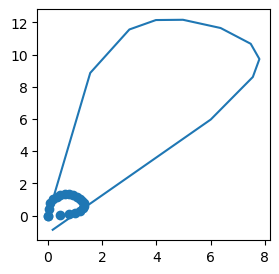

In [76]:
robot = FakeRobot()
curve = np.array([[0,0],[0,3],[3,0],[0,0]])

for vr, vl in bezier_turns(curve):
    robot.go_diff(vl*.87,vr*.87)
    robot._step()
robot.stop()

fig, ax = plt.subplots(figsize=(3,3))
ax.plot(*np.array(robot.pos_history).T)
ax.scatter(*bezier_cubic(curve).T)
#ax.set_xlim(0,6)
#ax.set_ylim(-3,3)
plt.show()

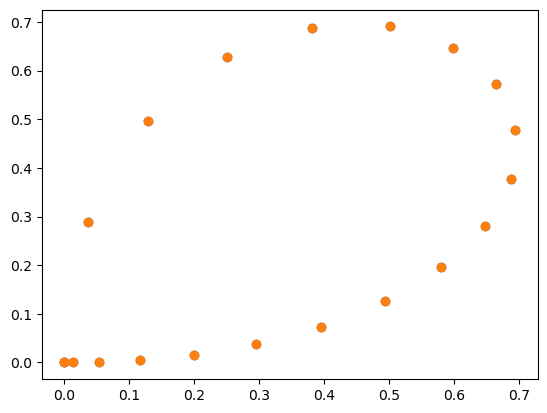

In [5]:
a = np.array([0,0])
b = np.array([1,0])
c = np.array([1,1])
d = np.array([0,1])

# Use a quarter sine for the ease-in

sine     = [math.sin(i) for i in np.linspace(0,math.pi/2,200)]
int_sine = [-math.cos(i)+1 for i in np.linspace(0,math.pi/2,20)]

#res = np.array([b + ((1-t)**2)*(a-b) + (t**2)*(c-b) for t in int_sine])
#plt.scatter(*res.T)

def lerp(t, a, b):
    # Interpolate line
    return (1-t)*a + t*b

def bezier_quad(t,a,b,c):
    # Calculate point
    p0 = lerp(t,a,b)
    p1 = lerp(t,b,c)
    p2 = lerp(t,p0,p1)
    
    return p2, d

def bezier(t, p):
    # de_casteljau
    res = p.copy()
    for a in range(len(res)):
        for i in reversed(range(a)):
            res[i] = lerp(t, res[i], res[i+1])
    
    return res[0]

def ease_in(t):
    # integral of sin
    return 1-math.cos(t*.5*math.pi)
    
accel = [ease_in(t) for t in np.linspace(0,1,20)]
curve = np.array([bezier(t,[a,b,c,d,a]) for t in accel])
plt.scatter(*curve.T)

res = [[0,0]]
pos, speed = np.array([0.,0.]), .3
for a,b in zip(curve[:-1], curve[1:]):
    # zip 2 bezier curves together, numeric differention 
    pos += (b-a) # use this to calculate angle + speed
    res.append(pos.copy())

plt.scatter(*np.array(res).T)
plt.show()